### 1.Preparar el entorno

In [1]:
!nvidia-smi 

Sun Nov 30 21:15:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.31                 Driver Version: 581.31         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              1W /   35W |     116MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%pip install ultralytics
%pip install ipython
%pip install ultralytics shapely pandas tqdm requests pillow

### 2.Subir el ZIP exportado de Roboflow

Arrastren a la barra lateral de Colab el zip pls

In [3]:
import zipfile

zip_path = "./content/Dataset_con_negativos.zip"
extract_path = "./content/fedapur"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

extract_path


'./content/fedapur'

Revisar que el YAML apunte a las rutas correctas

In [3]:
!cat ./content/fedapur/Dataset_con_negativos/data.yaml


"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## 3.Entrenar YOLOv8

Se empieza con el modelo pequeño (yolov8n) porque el dataset es reducido.
Luego, si la precisión lo permite, puede subir a yolov8s.

In [5]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.train(
    data="./content/fedapur/Dataset_con_negativos/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    device=0  # GPU T4
)

New https://pypi.org/project/ultralytics/8.3.233 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.231  Python-3.10.19 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./content/fedapur/Dataset_con_negativos/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False,

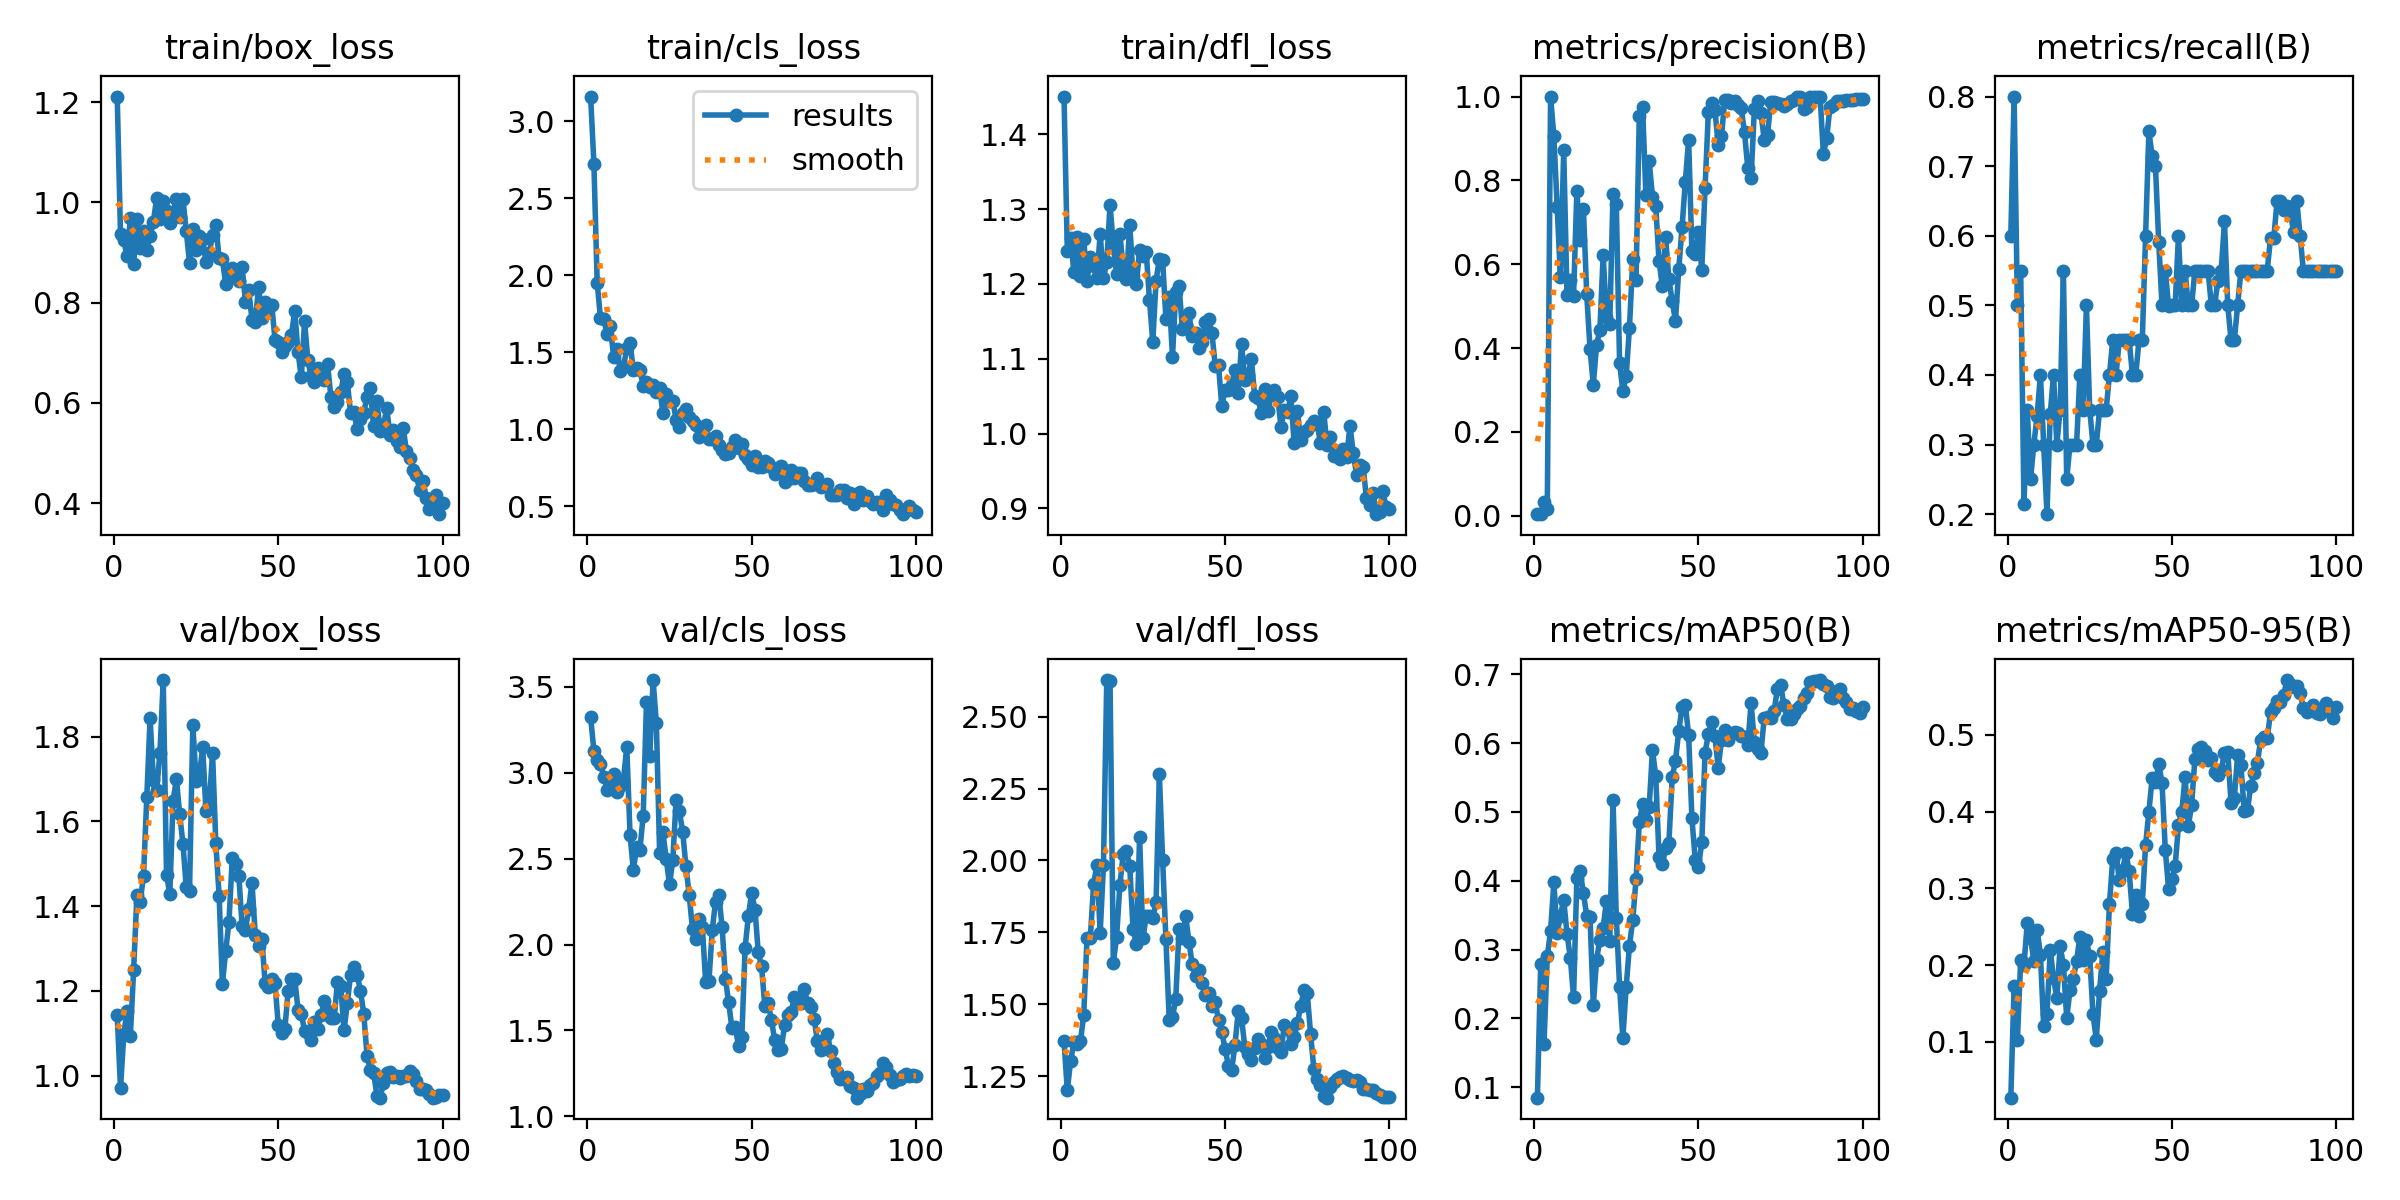

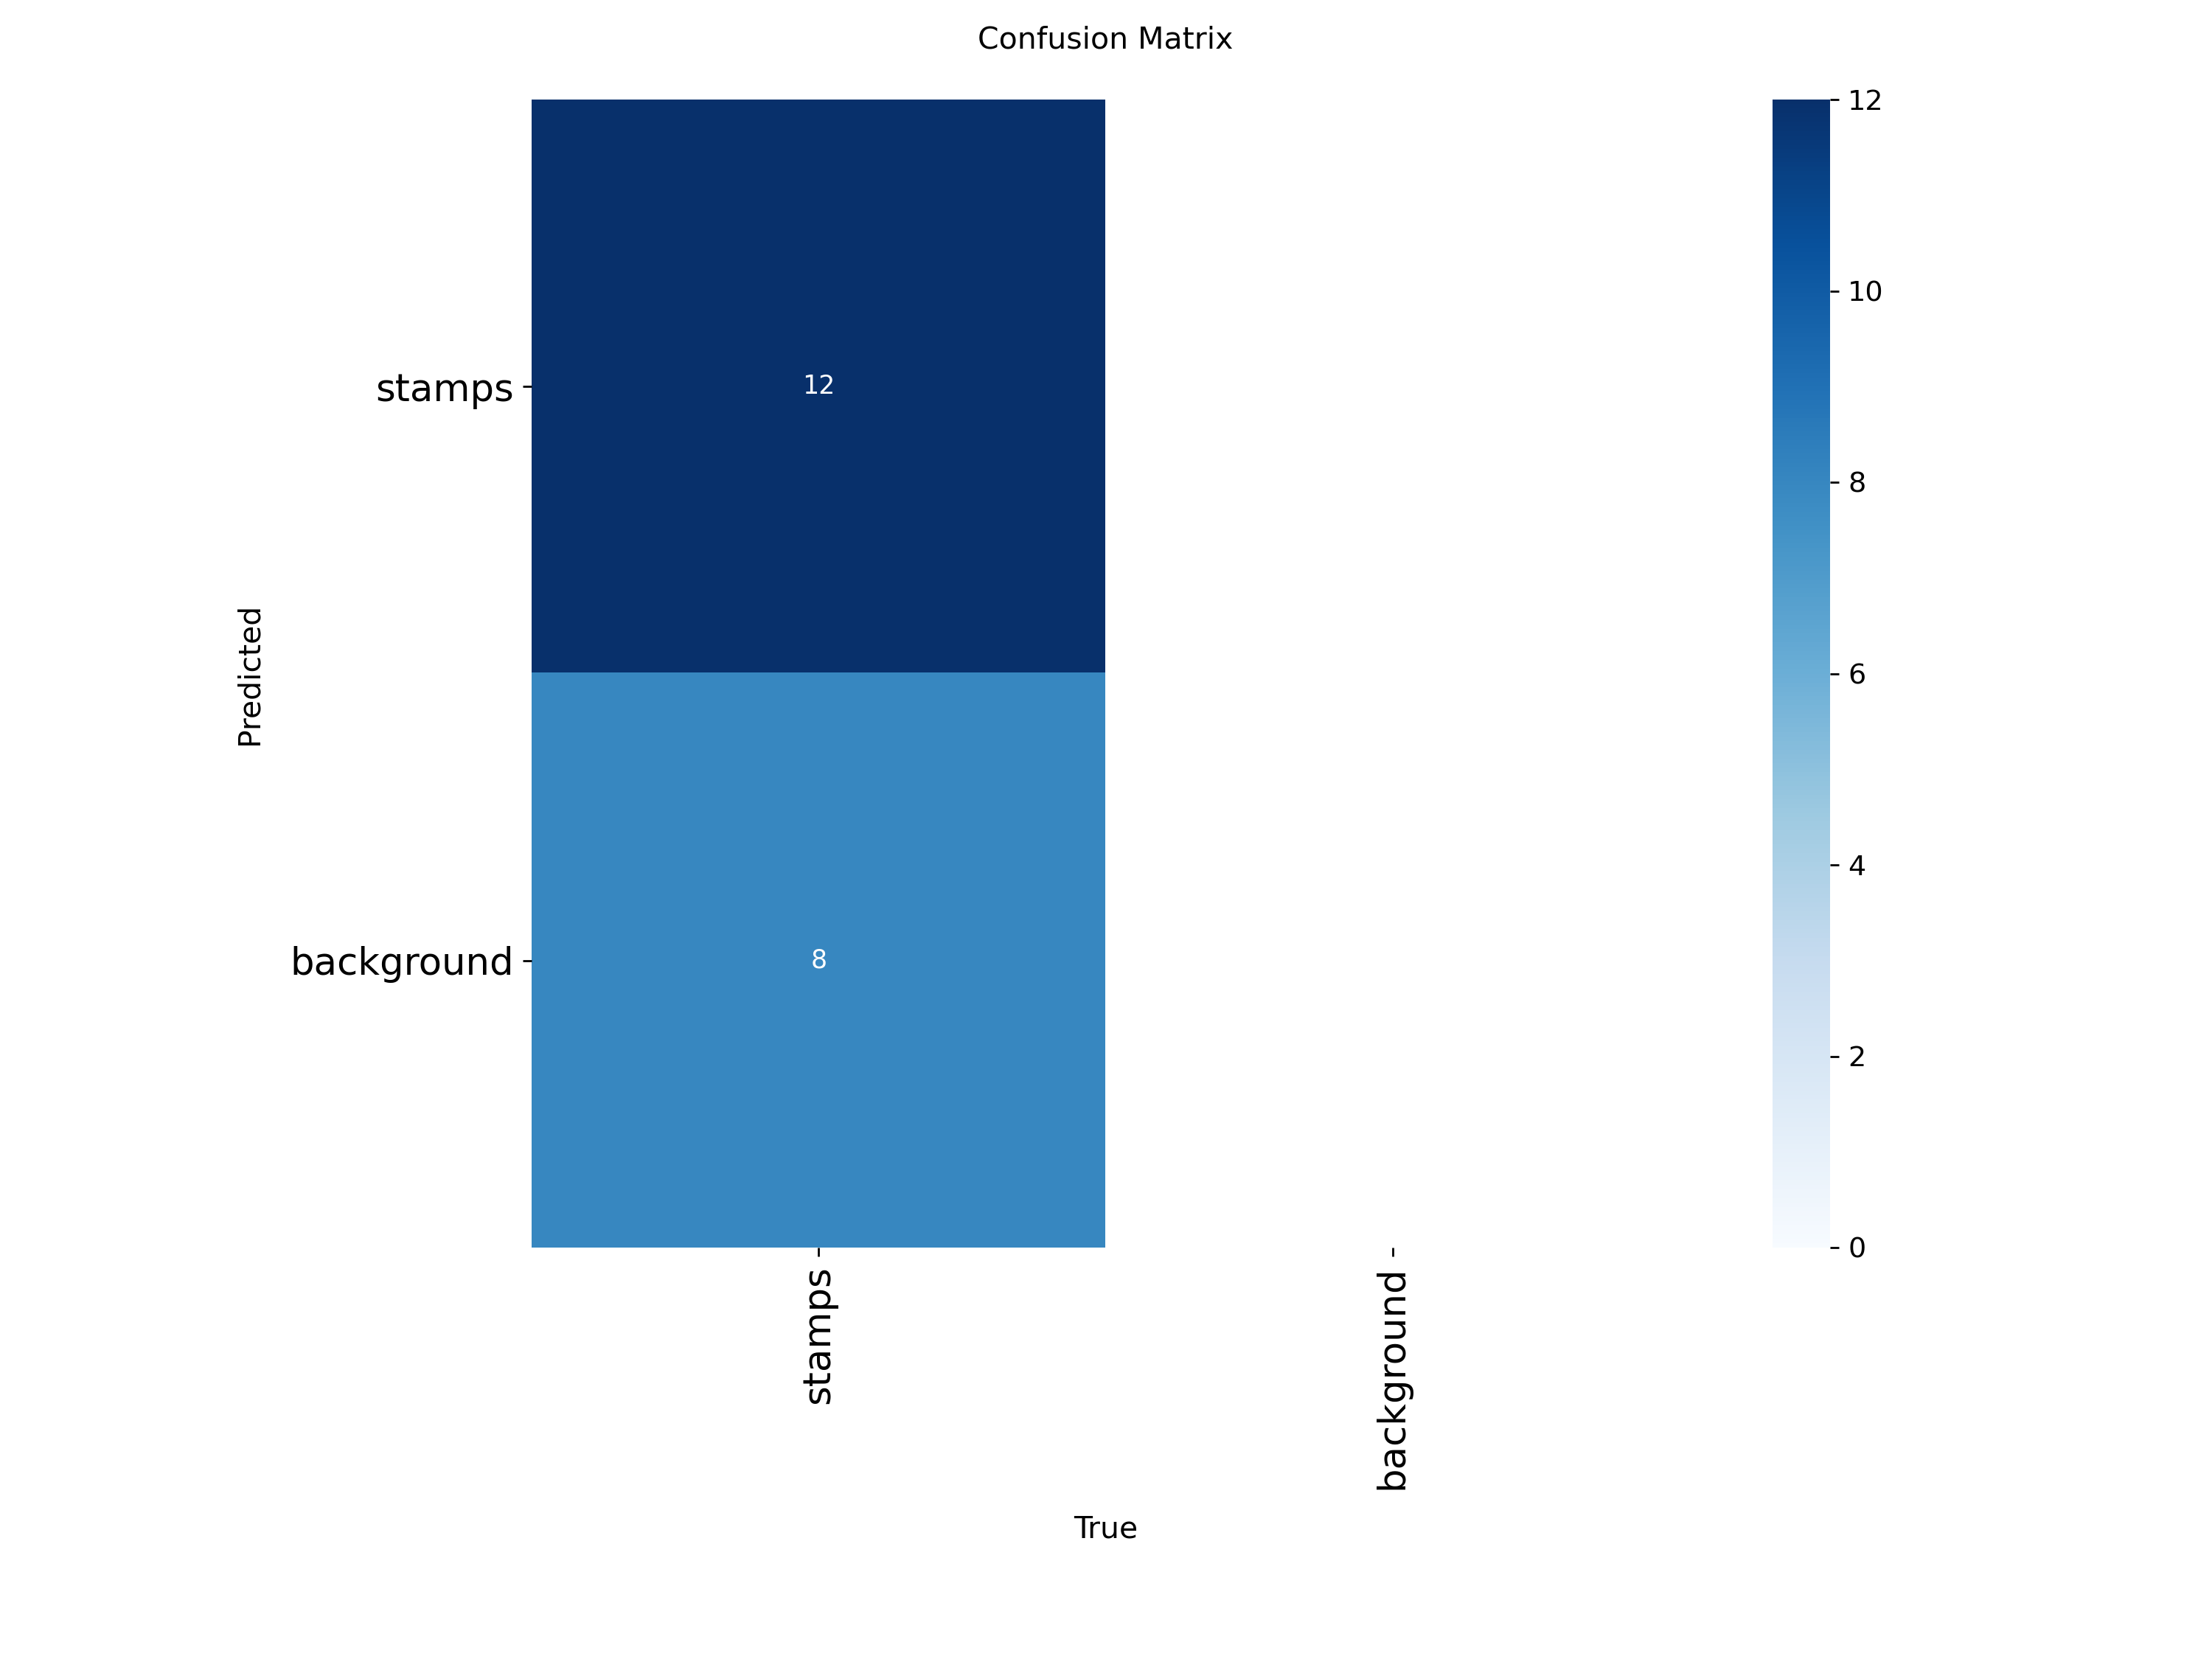

In [7]:
from IPython.display import Image, display

display(Image('./runs/detect/train2/results.png'))
display(Image('./runs/detect/train2/confusion_matrix.png'))


Las curvas del entrenamiento muestran un comportamiento estable y coherente con un modelo que está aprendiendo correctamente a detectar el sello FEDAPUR.

### 3.1Evolución de las pérdidas (losses)
- Las pérdidas `train/box_loss`, `train/cls_loss` y `train/dfl_loss` descienden de forma progresiva a lo largo de las épocas, lo que indica que el modelo ajusta cada vez mejor las cajas y reconoce con mayor precisión la clase del sello.
- En el conjunto de validación, las pérdidas presentan más ruido debido al tamaño reducido del dataset, pero siguen una tendencia similar y terminan estabilizándose. Esto sugiere que no hay un sobreajuste severo.



### 3.2 Métricas de desempeño
- La precisión aumenta de manera constante hasta acercarse a **1.0**, indicando que la mayoría de las detecciones positivas realmente corresponden al sello.
- El recall mejora con el paso de las épocas, aunque se estabiliza alrededor de **~0.55**, lo que implica que el modelo aún deja escapar algunos sellos. Con más datos o un threshold más bajo podría mejorar.
- Las métricas **mAP50** y **mAP50-95** muestran una tendencia ascendente sólida, lo que confirma que el modelo está generalizando correctamente y no solo memorizando ejemplos del entrenamiento.

En general, los resultados reflejan un entrenamiento exitoso y un modelo funcional para la tarea de detección del sello FEDAPUR.





### 3.3.Matriz de confusión
- El modelo reconoce correctamente varios casos de `stamps → stamps`, demostrando que distingue bien el sello.
- Se observan algunos falsos negativos (`stamps → background`), lo cual coincide con el recall moderado obtenido.
- Los falsos positivos hacia la clase `stamps` son mínimos, lo cual es valioso para evitar conteos inflados o erróneos en el análisis final.

## 4.Validación del modelo usando imágenes del conjunto `test/`

Para comprobar el correcto funcionamiento del modelo entrenado, el equipo ejecutó inferencia directamente sobre la carpeta `test/`.  
Este paso permite verificar:

- Que el modelo reconoce adecuadamente la clase objetivo.  
- Que las cajas delimitadoras se dibujan y guardan correctamente.  
- Que los resultados son coherentes con las métricas mostradas en el entrenamiento.

A continuación se muestra el bloque de código utilizado para esta fase.


In [8]:
# --- Inferencia sobre el conjunto de prueba (test) ---

from ultralytics import YOLO
import os

# Cargar el modelo entrenado
model = YOLO("./runs/detect/train2/weights/best.pt")

# Ruta correcta del directorio test (solo imágenes)
test_dir = "./content/fedapur/Dataset_con_negativos/test/images"

# Carpeta donde se guardarán los resultados
output_dir = "./content/inference_test_results"
os.makedirs(output_dir, exist_ok=True)

# Ejecución de inferencia
results = model.predict(
    source=test_dir,
    save=True,
    save_txt=True,
    project=output_dir,
    name="detections_test",
    conf=0.25
)

print("Inferencia completada. Resultados guardados en:", output_dir + "/detections_test")



image 1/11 c:\Users\mazar\Desktop\Metodologia\content\fedapur\Dataset_con_negativos\test\images\05-medellin-axl-hdz_1_jpg.rf.6d3a3955dcf788d533ce9239d924a326.jpg: 640x640 1 stamps, 27.1ms
image 2/11 c:\Users\mazar\Desktop\Metodologia\content\fedapur\Dataset_con_negativos\test\images\8_png.rf.85ceb2565ebc332202aa5fce0025c04a.jpg: 640x640 1 stamps, 28.1ms
image 3/11 c:\Users\mazar\Desktop\Metodologia\content\fedapur\Dataset_con_negativos\test\images\9_png.rf.4577c22a013fd792de62a48577a3eaa8.jpg: 640x640 2 stampss, 26.9ms
image 4/11 c:\Users\mazar\Desktop\Metodologia\content\fedapur\Dataset_con_negativos\test\images\Casa-Chiapas-CDMX-01-scaled-e1697139032980-1160x700_jpg.rf.6b70eb9e24c11122a1f77c1ce04ca235.jpg: 640x640 1 stamps, 27.0ms
image 5/11 c:\Users\mazar\Desktop\Metodologia\content\fedapur\Dataset_con_negativos\test\images\Despojo_Predio_Queretaro-3-scaled_jpg.rf.3c241b5393e733c5843a7fbab0c304fb.jpg: 640x640 1 stamps, 26.7ms
image 6/11 c:\Users\mazar\Desktop\Metodologia\content\fe

## 5.Revisión de resultados

El equipo revisó las imágenes generadas en `inference_test_results/detections_test/`, donde cada archivo contiene:

- La imagen con las cajas de detección dibujadas.  
- El archivo `.txt` con las coordenadas normalizadas de cada predicción.  

A continuación, se muestran algunos ejemplares:

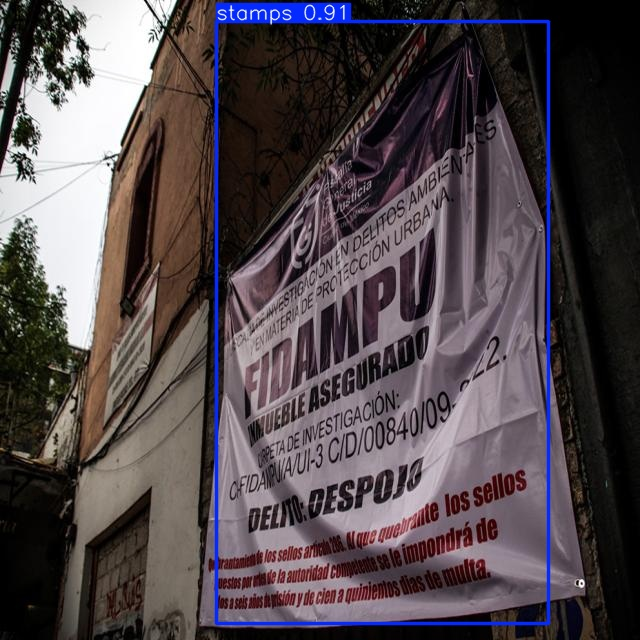

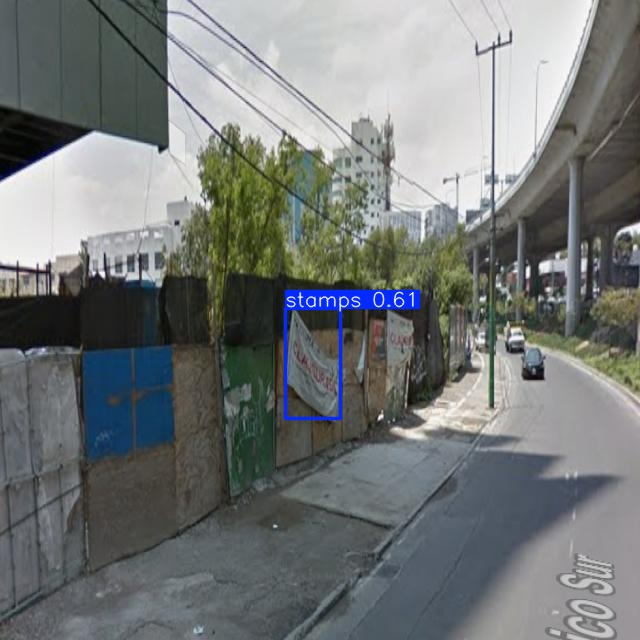

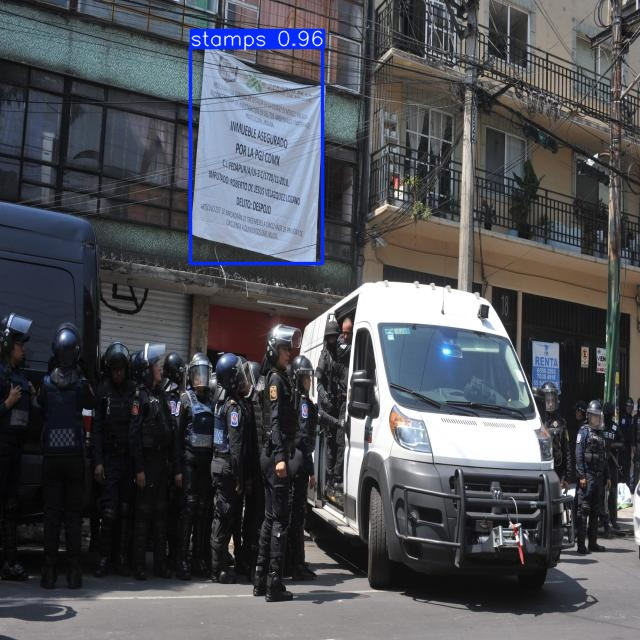

In [9]:
display(Image('./content/inference_test_results/detections_test/05-medellin-axl-hdz_1_jpg.rf.6d3a3955dcf788d533ce9239d924a326.jpg'))
display(Image('./content/inference_test_results/detections_test/8_png.rf.85ceb2565ebc332202aa5fce0025c04a.jpg'))
display(Image('./content/inference_test_results/detections_test/Despojo_Predio_Queretaro-3-scaled_jpg.rf.3c241b5393e733c5843a7fbab0c304fb.jpg'))

La validación confirmó que el modelo está listo para ser aplicado sobre imágenes obtenidas mediante KartaView.

El siguiente paso consiste en ejecutar inferencia sobre fotografías reales y continuar con la etapa geoespacial del proyecto.


# 6.Inferencia con imágenes descargadas desde KartaView (Colonia Juárez, 2024)

 El equipo decidió incorporar imágenes reales de la colonia Juárez (Ciudad de México) obtenidas desde KartaView, de forma que el modelo fuera evaluado con escenarios urbanos naturales. Para ello, primero se realizó una descarga del set de imágenes correspondiente al año 2024 y, posteriormente, se aplicó el modelo entrenado para validar su desempeño fuera del dataset original.

El proceso se divide en dos etapas:

1. Descarga automática de imágenes desde KartaView

2. Inferencia del modelo YOLO sobre dichas imágenes

## 6.1.Descarga de imágenes desde KartaView (2024)
El equipo decidió emplear el polígono oficial de la colonia Juárez para limitar estrictamente la descarga de imágenes de KartaView.
Para ello, se realizan las siguientes etapas:

1. Cargar el GeoJSON de la Colonia Juárez.  
2. Generar una cuadrícula de puntos dentro del polígono y consultar la API pública de KartaView (OpenStreetCam) por cada punto.  
3. Por cada `photo_id` devuelto: obtener metadatos completos, filtrar por **año 2024** y confirmar que la foto cae dentro del polígono.  
4. Descargar la imagen y salvar metadatos en `kartaview_metadata.csv`.

### Versión Kartaview

In [ ]:
# -----------------------------
# 0. Requisitos
# -----------------------------
# !pip install shapely pandas tqdm requests pillow

import json
import requests
import numpy as np
import os
from shapely.geometry import shape, Point
from PIL import Image
from io import BytesIO
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# 1. Configuración
# -----------------------------
geojson_path = "./content/colonia_juarez.geojson"
images_folder = "./content/kartaview_juarez_2017"
os.makedirs(images_folder, exist_ok=True)

ids_csv = "./content/kartaview_photo_ids.csv"
metadata_csv = "./content/kartaview_metadata.csv"

grid_size = 0.00009         # Ajustar según densidad de puntos
year_filter = "2017"
max_images = 10000

api_workers = 8
download_workers = 16
sleep_between_queries = 0.05

# -----------------------------
# 2. Cargar GeoJSON
# -----------------------------
with open(geojson_path, "r", encoding="utf-8") as f:
    gj = json.load(f)

polygon = shape(gj[0]["geometry"])
minx, miny, maxx, maxy = polygon.bounds

xs = np.arange(minx, maxx, grid_size)
ys = np.arange(miny, maxy, grid_size)

points = []
for x in xs:
    for y in ys:
        p = Point(x, y)
        if polygon.contains(p):
            points.append((y, x))  # lat, lon

print(f"[INFO] Puntos dentro del polígono: {len(points)}")

# -----------------------------
# 3. Paso 1: Recolectar photo_id
# -----------------------------
def fetch_photos(point):
    lat, lng = point
    try:
        search_url = f"https://api.openstreetcam.org/2.0/photo/?lat={lat}&lng={lng}&radius=50"
        r = requests.get(search_url, timeout=5)
        data = r.json()
        return [p["id"] for p in data.get("result", {}).get("data", []) if "id" in p]
    except:
        return []

print("[INFO] Recolectando photo_id...")
photo_ids = set()
with ThreadPoolExecutor(max_workers=api_workers) as executor:
    for ids in tqdm(executor.map(fetch_photos, points), total=len(points)):
        photo_ids.update(ids)
        if len(photo_ids) >= max_images:
            break

photo_ids = list(photo_ids)[:max_images]
pd.DataFrame({"photo_id": photo_ids}).to_csv(ids_csv, index=False)
print(f"[INFO] CSV provisional con photo_id guardado: {ids_csv}")
print(f"[INFO] Total photo_id recolectados: {len(photo_ids)}")

# -----------------------------
# 4. Paso 2: Procesar metadata en paralelo
# -----------------------------
def process_photo_id(pid):
    try:
        info_url = f"https://api.openstreetcam.org/2.0/photo/{pid}"
        r = requests.get(info_url, timeout=5)
        result = r.json().get("result", {}).get("data") or {}
        timestamp = result.get("dateAdded") or result.get("date") or result.get("shotDate")
        if not timestamp or year_filter not in str(timestamp):
            return None

        lat_img = result.get("lat") or result.get("latitude")
        lng_img = result.get("lng") or result.get("longitude")
        if lat_img is None or lng_img is None:
            return None

        pt = Point(float(lng_img), float(lat_img))
        if not polygon.contains(pt):
            return None

        image_url = result.get("imageLthUrl") or result.get("imageProcUrl") or \
                    (result.get("fileurl") or "").replace("{{sizeprefix}}", "l")
        if not image_url:
            return None

        return {
            "photo_id": pid,
            "lat": float(lat_img),
            "lng": float(lat_img),
            "image_url": image_url,
            "timestamp": timestamp,
            "sequence_id": result.get("sequenceId") or result.get("sequence_id"),
            "heading": result.get("heading")
        }
    except:
        return None

print("[INFO] Procesando metadata en paralelo...")
metadata = []
with ThreadPoolExecutor(max_workers=api_workers) as executor:
    for item in tqdm(executor.map(process_photo_id, photo_ids), total=len(photo_ids)):
        if item:
            metadata.append(item)

# Asignar filenames
for i, item in enumerate(metadata):
    item["filename"] = f"kv_{i:05d}.jpg"

df = pd.DataFrame(metadata)
df.to_csv(metadata_csv, index=False)
print(f"[INFO] Metadata final guardada: {metadata_csv}")
print(f"[INFO] Total imágenes a descargar: {len(metadata)}")

# -----------------------------
# 5. Paso 3: Descargar imágenes en paralelo
# -----------------------------
def download_image(item):
    try:
        resp = requests.get(item["image_url"], timeout=15)
        if resp.status_code != 200:
            return
        img = Image.open(BytesIO(resp.content)).convert("RGB")
        filepath = os.path.join(images_folder, item["filename"])
        img.save(filepath, format="JPEG", quality=90)
    except:
        pass

print("[INFO] Descargando imágenes en paralelo...")
with ThreadPoolExecutor(max_workers=download_workers) as executor:
    list(tqdm(executor.map(download_image, metadata), total=len(metadata)))

print("[INFO] Descarga completada.")


[INFO] Puntos dentro del polígono: 16648
[INFO] Recolectando photo_id...


100%|██████████| 16648/16648 [43:29<00:00,  6.38it/s] 


[INFO] CSV provisional con photo_id guardado: ./content/kartaview_photo_ids.csv
[INFO] Total photo_id recolectados: 7766
[INFO] Procesando metadata en paralelo...


100%|██████████| 7766/7766 [18:35<00:00,  6.96it/s]


[INFO] Metadata final guardada: ./content/kartaview_metadata.csv
[INFO] Total imágenes a descargar: 3721
[INFO] Descargando imágenes en paralelo...


100%|██████████| 3721/3721 [05:25<00:00, 11.42it/s]

[INFO] Descarga completada.


## Versión GoogleStreetView

In [ ]:
# -----------------------------
# 0. Requisitos 
# -----------------------------

import json
import requests
import numpy as np
import os
import time
from shapely.geometry import shape, Point
from PIL import Image
from io import BytesIO
import pandas as pd
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# -----------------------------
# 1. Configuración de Google Street View
# -----------------------------
GOOGLE_API_KEY = "NadaPorAquí"

In [ ]:
geojson_path = "./content/colonia_juarez.geojson"
images_folder = "./content/google_street_view_juarez"
metadata_csv = "./content/google_street_view_metadata.csv"

# Verificar si ya existen la carpeta y el CSV
if os.path.exists(images_folder) and os.path.exists(metadata_csv):
    print(f"[INFO] La carpeta '{images_folder}' y el CSV '{metadata_csv}' ya existen. Saltando descarga.")
else:

    os.makedirs(images_folder, exist_ok=True)

    # Años permitidos
    year_filter = [2019, 2020, 2021, 2022, 2023, 2024]

    # Límite por año
    max_per_year = 1000     # <---- LÍMITE DE PANORAMAS POR AÑO

    # Grilla
    grid_size = 0.0003      # ~55 metros

    # Parámetros Street View Static
    IMAGE_SIZE = "640x480"
    FOV = 120
    HEADINGS = [0, 90, 180, 270]  # 4 direcciones

    # Concurrencia
    api_workers = 8
    download_workers = 16
    sleep_between_queries = 0.05


    # -------------------------------------------------------------------
    # 1. Cargar polígono y generar puntos en la grilla
    # -------------------------------------------------------------------

    with open(geojson_path, "r", encoding="utf-8") as f:
        gj = json.load(f)

    polygon = shape(gj[0]["geometry"])

    minx, miny, maxx, maxy = polygon.bounds

    xs = np.arange(minx, maxx, grid_size)
    ys = np.arange(miny, maxy, grid_size)

    points = []
    for x in xs:
        for y in ys:
            p = Point(x, y)
            if polygon.contains(p):
                points.append((y, x))  # lat, lon

    print(f"[INFO] Puntos de la grilla dentro del polígono: {len(points)}")


    # -------------------------------------------------------------------
    # 2. Buscar pano_ids via Street View Metadata API
    # -------------------------------------------------------------------

    def fetch_pano_metadata(point):
        """
        Consulta la API Street View Metadata para obtener pano_id, fecha y coordenadas.
        """
        lat, lng = point

        try:
            metadata_url = "https://maps.googleapis.com/maps/api/streetview/metadata"

            params = {
                'location': f"{lat},{lng}",
                'key': GOOGLE_API_KEY,
                'source': 'outdoor',
                'radius': 50
            }

            r = requests.get(metadata_url, params=params, timeout=5)
            r.raise_for_status()
            data = r.json()

            if data.get("status") != "OK":
                return None

            pano_id = data.get("pano_id")
            date_str = data.get("date")  # YYYY-MM

            lat_img = data.get("location", {}).get("lat")
            lng_img = data.get("location", {}).get("lng")

            # ---- Filtro de años ----
            pano_year = int(date_str.split("-")[0])
            if pano_year not in year_filter:
                return None

            # Verificar que el panorama esté dentro del polígono
            pt = Point(float(lng_img), float(lat_img))
            if not polygon.contains(pt):
                return None

            return {
                "pano_id": pano_id,
                "lat": float(lat_img),
                "lng": float(lng_img),
                "date": date_str,
                "year": pano_year,
            }

        except:
            return None

        finally:
            time.sleep(sleep_between_queries)


    # -------------------------------------------------------------------
    # 3. Filtrar + limitar a 1000 panoramas por año
    # -------------------------------------------------------------------

    print("[INFO] Buscando panoramas por año...")

    metadata_final = []
    pano_ids_set = set()
    per_year_count = {year: 0 for year in year_filter}

    def process_result(item):
        if not item:
            return

        pano_id = item["pano_id"]
        year = item["year"]

        # Si ya alcanzó el límite por año
        if per_year_count[year] >= max_per_year:
            return

        # Si está duplicado
        if pano_id in pano_ids_set:
            return

        # Registrar el panorama
        pano_ids_set.add(pano_id)
        per_year_count[year] += 1
        metadata_final.append(item)


    with ThreadPoolExecutor(max_workers=api_workers) as ex:
        for result in tqdm(ex.map(fetch_pano_metadata, points), total=len(points)):
            process_result(result)

            # Si TODOS los años llegaron al límite → detener
            if all(per_year_count[y] >= max_per_year for y in year_filter):
                break

    print("[INFO] Total recopilado por año:")
    for y in year_filter:
        print(f"  Año {y}: {per_year_count[y]} panoramas")


    # -------------------------------------------------------------------
    # 4. Guardar metadata
    # -------------------------------------------------------------------

    for i, item in enumerate(metadata_final):
        item["filename"] = f"gs_{i:05d}_{item['pano_id']}"

    df = pd.DataFrame(metadata_final)
    df.to_csv(metadata_csv, index=False)

    print(f"[INFO] Metadata guardada en: {metadata_csv}")
    print(f"[INFO] Total panoramas únicos: {len(metadata_final)}")


    # -------------------------------------------------------------------
    # 5. Descargar imágenes (4 orientaciones por panorama)
    # -------------------------------------------------------------------

    def download_streetview_image(item):
        pano_id = item["pano_id"]
        base = item["filename"]

        for heading in HEADINGS:
            try:
                static_url = "https://maps.googleapis.com/maps/api/streetview"
                params = {
                    'pano': pano_id,
                    'size': IMAGE_SIZE,
                    'fov': FOV,
                    'heading': heading,
                    'pitch': 0,
                    'key': GOOGLE_API_KEY
                }

                resp = requests.get(static_url, params=params, timeout=15)
                if resp.status_code != 200:
                    continue

                img_path = os.path.join(images_folder, f"{base}_h{heading}.jpg")
                img = Image.open(BytesIO(resp.content)).convert("RGB")
                img.save(img_path, format="JPEG", quality=90)

            except:
                pass


    print("[INFO] Descargando imágenes (4 por panorama)...")

    with ThreadPoolExecutor(max_workers=download_workers) as ex:
        list(tqdm(ex.map(download_streetview_image, metadata_final), total=len(metadata_final)))

    print("[INFO] Descarga completada.")


[INFO] Puntos de la grilla dentro del polígono: 3364
[INFO] Buscando panoramas por año...


100%|██████████| 3364/3364 [01:28<00:00, 38.22it/s]


[INFO] Total recopilado por año:
  Año 2019: 63 panoramas
  Año 2020: 0 panoramas
  Año 2021: 32 panoramas
  Año 2022: 291 panoramas
  Año 2023: 146 panoramas
  Año 2024: 1000 panoramas
[INFO] Metadata guardada en: ./content/google_street_view_metadata.csv
[INFO] Total panoramas únicos: 1532
[INFO] Descargando imágenes (4 por panorama)...


100%|██████████| 1532/1532 [01:43<00:00, 14.76it/s]

[INFO] Descarga completada.


In [16]:
geojson_path = "./content/colonia_juarez.geojson"
images_folder = "./content/google_street_view_juarez"
metadata_csv = "./content/google_street_view_metadata.csv"

# Parámetros
year_filter = [2017,2018,2019, 2020, 2021, 2022, 2023, 2024]
max_global = 6000           # Límite global de panoramas nuevos
grid_size = 0.0002         # Tamaño de la grilla (~55 metros)
IMAGE_SIZE = "640x480"
FOV = 120
HEADINGS = [0, 90, 180, 270]  # 4 direcciones
api_workers = 8
download_workers = 16
sleep_between_queries = 0.05

# -------------------------------------------------------------------
# 1. Cargar CSV existente (si existe)
# -------------------------------------------------------------------
os.makedirs(images_folder, exist_ok=True)

existing_metadata = []
existing_locations = set()
existing_pano_ids = set()

if os.path.exists(metadata_csv):
    print("[INFO] CSV existente encontrado. Cargando metadata...")
    df_old = pd.read_csv(metadata_csv)
    existing_metadata = df_old.to_dict(orient="records")
    existing_pano_ids = set(df_old["pano_id"].astype(str))
    for _, row in df_old.iterrows():
        key = (round(row["lat"], 6), round(row["lng"], 6))
        existing_locations.add(key)
    print(f"[INFO] Panoramas ya existentes: {len(existing_pano_ids)}")
else:
    print("[INFO] No existe CSV previo. Se generará desde cero.")

# -------------------------------------------------------------------
# 2. Cargar polígono y generar puntos de la grilla
# -------------------------------------------------------------------
with open(geojson_path, "r", encoding="utf-8") as f:
    gj = json.load(f)
polygon = shape(gj[0]["geometry"])
minx, miny, maxx, maxy = polygon.bounds

xs = np.arange(minx, maxx, grid_size)
ys = np.arange(miny, maxy, grid_size)

points = []
for x in xs:
    for y in ys:
        p = Point(x, y)
        if polygon.contains(p):
            points.append((y, x))  # lat, lon

print(f"[INFO] Puntos totales de la grilla dentro del polígono: {len(points)}")

# -------------------------------------------------------------------
# 3. Filtrar SOLO puntos nuevos (para no gastar en API)
# -------------------------------------------------------------------
new_points = []
for lat, lon in points:
    key = (round(lat, 6), round(lon, 6))
    if key not in existing_locations:
        new_points.append((lat, lon))

print(f"[INFO] Puntos nuevos a consultar en la API: {len(new_points)}")

if not new_points:
    print("[INFO] No hay puntos nuevos, se omiten requests a la API.")

# -------------------------------------------------------------------
# 4. Función para consultar metadata
# -------------------------------------------------------------------
def fetch_pano_metadata(point):
    lat, lng = point
    try:
        metadata_url = "https://maps.googleapis.com/maps/api/streetview/metadata"
        params = {
            'location': f"{lat},{lng}",
            'key': GOOGLE_API_KEY,
            'source': 'outdoor',
            'radius': 50
        }
        r = requests.get(metadata_url, params=params, timeout=5)
        r.raise_for_status()
        data = r.json()
        if data.get("status") != "OK":
            return None

        pano_id = data.get("pano_id")
        date_str = data.get("date")  # YYYY-MM
        lat_img = data.get("location", {}).get("lat")
        lng_img = data.get("location", {}).get("lng")

        pano_year = int(date_str.split("-")[0])
        if pano_year not in year_filter:
            return None

        pt = Point(float(lng_img), float(lat_img))
        if not polygon.contains(pt):
            return None

        return {
            "pano_id": pano_id,
            "lat": float(lat_img),
            "lng": float(lng_img),
            "date": date_str,
            "year": pano_year
        }

    except:
        return None
    finally:
        time.sleep(sleep_between_queries)

# -------------------------------------------------------------------
# 5. Procesar resultados y limitar globalmente
# -------------------------------------------------------------------
metadata_final = []
global global_count
global_count = 0

def process_result(item):
    global global_count
    if not item:
        return
    pano_id = str(item["pano_id"])
    if pano_id in existing_pano_ids:
        return
    if global_count >= max_global:
        return
    existing_pano_ids.add(pano_id)
    metadata_final.append(item)
    global_count += 1

if new_points:
    print("[INFO] Consultando nuevos panoramas...")
    with ThreadPoolExecutor(max_workers=api_workers) as ex:
        for result in tqdm(ex.map(fetch_pano_metadata, new_points), total=len(new_points)):
            process_result(result)
            if global_count >= max_global:
                break

print(f"[INFO] Panoramas nuevos agregados: {len(metadata_final)}")

# -------------------------------------------------------------------
# 6. Guardar CSV actualizado
# -------------------------------------------------------------------
start_index = len(existing_metadata)
for i, item in enumerate(metadata_final, start=start_index):
    item["filename"] = f"gs_{i:05d}_{item['pano_id']}"

all_metadata = existing_metadata + metadata_final
df = pd.DataFrame(all_metadata)
df.to_csv(metadata_csv, index=False)
print(f"[INFO] CSV actualizado. Total panoramas: {len(all_metadata)}")

# -------------------------------------------------------------------
# 7. Descargar imágenes faltantes de los panoramas
# -------------------------------------------------------------------
def download_streetview_image(item):
    pano_id = item["pano_id"]
    base = item["filename"]
    for heading in HEADINGS:
        try:
            img_path = os.path.join(images_folder, f"{base}_h{heading}.jpg")
            if os.path.exists(img_path):
                continue  # ya existe
            static_url = "https://maps.googleapis.com/maps/api/streetview"
            params = {
                'pano': pano_id,
                'size': IMAGE_SIZE,
                'fov': FOV,
                'heading': heading,
                'pitch': 0,
                'key': GOOGLE_API_KEY
            }
            resp = requests.get(static_url, params=params, timeout=15)
            if resp.status_code != 200:
                continue
            img = Image.open(BytesIO(resp.content)).convert("RGB")
            img.save(img_path, format="JPEG", quality=90)
        except:
            pass

# Solo intentar descargar imágenes si hay panoramas nuevos o faltantes
items_to_download = [item for item in all_metadata if any(
    not os.path.exists(os.path.join(images_folder, f"{item['filename']}_h{h}.jpg")) for h in HEADINGS
)]

if items_to_download:
    print(f"[INFO] Descargando imágenes faltantes: {len(items_to_download)} panoramas")
    with ThreadPoolExecutor(max_workers=download_workers) as ex:
        list(tqdm(ex.map(download_streetview_image, items_to_download), total=len(items_to_download)))
else:
    print("[INFO] No hay imágenes faltantes. Descarga omitida.")

print("[INFO] Proceso completado sin requests innecesarias a la API.")

[INFO] CSV existente encontrado. Cargando metadata...
[INFO] Panoramas ya existentes: 2729
[INFO] Puntos totales de la grilla dentro del polígono: 3364
[INFO] Puntos nuevos a consultar en la API: 3364
[INFO] Consultando nuevos panoramas...


100%|██████████| 3364/3364 [01:42<00:00, 32.84it/s]


[INFO] Panoramas nuevos agregados: 56
[INFO] CSV actualizado. Total panoramas: 2785
[INFO] Descargando imágenes faltantes: 59 panoramas


100%|██████████| 59/59 [00:05<00:00, 10.03it/s]

[INFO] Proceso completado sin requests innecesarias a la API.


##6.2.Inferencia del modelo sobre imágenes de KartaView
Una vez que el conjunto de imágenes se encuentra disponible, se aplica el modelo entrenado para validar si la red generaliza correctamente a escenarios urbanos reales.

1. Ejecutar inferencia con el modelo entrenado (Ultralytics YOLO) sobre cada imagen descargada.  
2. Guardar cada detección válida en:
   - `detections.csv` (tabla)  
   - `detections.geojson` (puntos con propiedades: photo_id, filename, confidence, date, sequence_id)


In [20]:
from tqdm import tqdm
import pandas as pd
import os
from ultralytics import YOLO
import json

# -----------------------------
# 4. Inferencia con Ultralytics YOLO (imagen por imagen)
# -----------------------------
yolo_weights = "./runs/detect/train2/weights/best.pt"
metadata_path = "./content/google_street_view_metadata.csv"
images_folder = "./content/google_street_view_juarez"
conf_threshold = 0.94

detections_csv = "detecciones_resultados.csv"
detections_geojson = "detecciones_mapa.geojson"

# Definir los sufijos de perspectiva
PERSPECTIVE_SUFFIXES = ["_h0", "_h90", "_h180", "_h270"]

print("[INFO] Cargando modelo YOLO entrenado...")
model = YOLO(yolo_weights)

# cargar metadata como DataFrame
df_meta = pd.read_csv(metadata_path)

detection_rows = []
features_geojson = {"type": "FeatureCollection", "features": []}

# iterar filas del metadata
total_inferences = len(df_meta) * len(PERSPECTIVE_SUFFIXES)

for _, rec in tqdm(df_meta.iterrows(), total=total_inferences, desc="Inferencia imágenes"):
    rec = rec.to_dict()

    # -----------------------------
    # FIX: filename del CSV NO tiene extensión
    # -----------------------------
    base_filename = rec["filename"]
    ext = ".jpg"  # ← forzamos extensión correcta

    # ITERAR SOBRE LAS 4 PERSPECTIVAS
    for suffix in PERSPECTIVE_SUFFIXES:
        perspective_filename = f"{base_filename}{suffix}{ext}"
        img_path = os.path.join(images_folder, perspective_filename)

        # Comprobar si la imagen existe
        if not os.path.exists(img_path):
            # print(f"[WARN] No existe: {perspective_filename}")
            continue

        # ----------------------------------------------------
        # BLOQUE DE INFERENCIA
        # ----------------------------------------------------
        try:
            results = model.predict(
                source=img_path,
                conf=conf_threshold,
                imgsz=640,
                save=False,
                verbose=False
            )
        except Exception as e:
            print(f"[WARN] Falló inferencia en {perspective_filename}: {e}")
            continue

        if len(results) == 0:
            continue

        r = results[0]
        boxes = getattr(r, "boxes", None)

        if boxes is None:
            continue

        try:
            confs = boxes.conf.tolist()
            xyxy = boxes.xyxy.tolist()
            classes = boxes.cls.tolist()
        except:
            continue

        # ----------------------------------------------------
        # GUARDAR DETECCIONES PARA CADA PERSPECTIVA
        # ----------------------------------------------------
        for i, conf in enumerate(confs):
            if conf < conf_threshold:
                continue

            lat = rec["lat"]
            lng = rec["lng"]

            bbox = xyxy[i]
            cls = int(classes[i])

            row = {
                "photo_id": rec.get("pano_id"),
                "filename": perspective_filename,
                "perspective": suffix,
                "lat": lat,
                "lng": lng,
                "confidence": float(conf),
                "class": cls,
                "bbox": bbox,
                "date": rec.get("date"),
                "year": rec.get("year")
            }

            detection_rows.append(row)

            feat = {
                "type": "Feature",
                "geometry": {"type": "Point", "coordinates": [lng, lat]},
                "properties": row
            }
            features_geojson["features"].append(feat)

# -----------------------------
# 5. Guardar resultados
# -----------------------------
df_det = pd.DataFrame(detection_rows)
df_det.to_csv(detections_csv, index=False)

with open(detections_geojson, "w", encoding="utf-8") as f:
    json.dump(features_geojson, f, ensure_ascii=False, indent=2)

print(f"[INFO] Detecciones guardadas en CSV: {detections_csv}")
print(f"[INFO] Detecciones guardadas en GeoJSON: {detections_geojson}")


[INFO] Cargando modelo YOLO entrenado...


Inferencia imágenes:  25%|██▌       | 2785/11140 [02:40<08:02, 17.30it/s]

[INFO] Detecciones guardadas en CSV: detecciones_resultados.csv
[INFO] Detecciones guardadas en GeoJSON: detecciones_mapa.geojson


In [1]:
from tqdm import tqdm
import pandas as pd
import os # Asegúrate de que `os` esté importado
from ultralytics import YOLO # Asegúrate de que `YOLO` esté accesible
import json # Asegúrate de que `json` esté importado

# -----------------------------
# 4. Inferencia con Ultralytics YOLO (imagen por imagen)
# -----------------------------
yolo_weights = "./runs/detect/train/weights/best.pt"
metadata_path = "./content/kartaview_metadata.csv"
images_folder = "./content/kartaview_juare_2017"
conf_threshold = 0.01

detections_csv = "detecciones_resultados_kv.csv"
detections_geojson = "detecciones_mapa_kv.geojson"

# Definir los sufijos de perspectiva

print("[INFO] Cargando modelo YOLO entrenado...")
# Asegúrate de que la clase YOLO esté definida o importada correctamente,
# asumiendo que está importada desde ultralytics.
model = YOLO(yolo_weights)

# cargar metadata como DataFrame
df_meta = pd.read_csv(metadata_path)

detection_rows = []
features_geojson = {"type": "FeatureCollection", "features": []}

# iterar filas del metadata
# La longitud total será 4 veces el número de filas para reflejar las 4 inferencias por fila
total_inferences = len(df_meta)

for _, rec in tqdm(df_meta.iterrows(), total=total_inferences, desc="Inferencia imágenes"):
    rec = rec.to_dict()  # convertir a dict
    
    # Obtener el nombre genérico del archivo (sin extensión si es necesario)
    base_filename, ext = os.path.splitext(rec["filename"])
    
    # ITERAR SOBRE LAS 4 PERSPECTIVAS
    #for suffix in PERSPECTIVE_SUFFIXES:
        # Construir el nombre de archivo específico para esta perspectiva
    perspective_filename = f"{base_filename}{ext}"
    img_path = os.path.join(images_folder, perspective_filename)

        # ----------------------------------------------------
        # BLOQUE DE INFERENCIA
        # ----------------------------------------------------
    try:
        # Comprobar si el archivo de imagen existe antes de intentar la inferencia
        if not os.path.exists(img_path):
            # Opcional: imprimir una advertencia si falta alguna imagen
            # print(f"[WARN] Archivo de imagen no encontrado: {perspective_filename}")
            continue 
                
        results = model.predict(source=img_path, conf=conf_threshold, imgsz=640, save=False)
    except Exception as e:
        print(f"[WARN] Falló inferencia en {perspective_filename}: {e}")
        continue

    if len(results) == 0:
        continue

    r = results[0]
    boxes = getattr(r, "boxes", None)
    if boxes is None:
        continue

    try:
        confs = boxes.conf.tolist()
        xyxy = boxes.xyxy.tolist()
        classes = boxes.cls.tolist()
    except:
        continue

        # ----------------------------------------------------
        # GUARDAR DETECCIONES PARA CADA PERSPECTIVA
        # ----------------------------------------------------
    for i, conf in enumerate(confs):
        if conf < conf_threshold:
                continue

        lat = rec["lat"]
        lng = rec["lng"]

        bbox = xyxy[i]
        cls = int(classes[i])

        row = {
            "photo_id": rec["photo_id"],
                # Guardar el nombre de archivo ESPECÍFICO inferido
            "filename": perspective_filename, 
                # Opcional: añadir la perspectiva o ángulo como columna 
            "lat": lat,
            "lng": lng,
            "confidence": float(conf),
            "class": cls,
            "bbox": bbox,
            "timestamp": rec.get("timestamp"),
            "sequence_id": rec.get("sequence_id")
        }
        detection_rows.append(row)

        feat = {
            "type": "Feature",
            "geometry": {"type": "Point", "coordinates": [lng, lat]},
            "properties": row
        }
        features_geojson["features"].append(feat)
            
# -----------------------------
# 5. Guardar resultados
# -----------------------------
df_det = pd.DataFrame(detection_rows)
df_det.to_csv(detections_csv, index=False)

with open(detections_geojson, "w", encoding="utf-8") as f:
    json.dump(features_geojson, f, ensure_ascii=False, indent=2)

print(f"[INFO] Detecciones guardadas en CSV: {detections_csv}")
print(f"[INFO] Detecciones guardadas en GeoJSON: {detections_geojson}")

[INFO] Cargando modelo YOLO entrenado...


KeyboardInterrupt: 

# 7.Evaluación de métricas sobre las imágenes de KartaView

Se considera necesario medir el rendimiento del modelo utilizando las imágenes de KartaView descargadas previamente.  
Para ello, se empleará el archivo `detections.csv` generado en el paso anterior, contrastándolo contra las etiquetas reales disponibles en el conjunto de prueba (`test/labels`).  

Esta evaluación no mide precisión absoluta, pero permite comparar cuántas detecciones coinciden espacialmente con ground truth y cuántas corresponden a falsos positivos.  
Se utilizará IoU (Intersection over Union) con un umbral estándar de 0.5 para determinar coincidencias válidas.

In [ ]:
import pandas as pd
import os
from shapely.geometry import box

detections_csv = "/content/kartaview_detections.csv"
test_labels_dir = "/content/fedapur/Dataset_con_negativos/test/labels"

df_det = pd.read_csv(detections_csv)

# Función para cargar labels YOLO (formato xywh normalizado)
def load_yolo_labels(label_path, img_w=640, img_h=640):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.split())
            xmin = (x - w/2) * img_w
            xmax = (x + w/2) * img_w
            ymin = (y - h/2) * img_h
            ymax = (y + h/2) * img_h
            boxes.append(box(xmin, ymin, xmax, ymax))
    return boxes

def IoU(a, b):
    inter = a.intersection(b).area
    union = a.union(b).area
    return inter / union if union > 0 else 0

true_positives = 0
false_positives = 0
iou_threshold = 0.5

for _, row in df_det.iterrows():
    img_path = row["image_path"]
    label_path = os.path.join(
        test_labels_dir,
        os.path.splitext(os.path.basename(img_path))[0] + ".txt"
    )

    pred_box = box(row["xmin"], row["ymin"], row["xmax"], row["ymax"])
    gt_boxes = load_yolo_labels(label_path)

    if not gt_boxes:
        false_positives += 1
        continue

    matched = any(IoU(pred_box, gt) >= iou_threshold for gt in gt_boxes)

    if matched:
        true_positives += 1
    else:
        false_positives += 1

precision = true_positives / (true_positives + false_positives + 1e-9)

print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("Precision estimada:", precision)


#8.Visualización comparativa de detecciones y etiquetas reales

Como parte del análisis cualitativo, el equipo necesita observar visualmente cómo se comparan las detecciones del modelo con las etiquetas del conjunto de prueba.  
El siguiente bloque dibuja, para cualquier imagen seleccionada, dos elementos:

1. Las **cajas reales (ground truth)** en color verde.  
2. Las **cajas detectadas por el modelo** en color rojo.  

Esto permite identificar errores comunes, comprender el comportamiento del modelo y evaluar casos en los que se detectan objetos incompletos, desplazados o falsos positivos.

